# Generalized nonlinear Schrödinger equation

## 📜 **Generalized NLSE Used in the Code**

The evolution of the complex envelope $ A(x, y, t; z) $ along the propagation axis $ z $ is governed by:

$$
\boxed{
\begin{aligned}
\frac{\partial A}{\partial z} &= \underbrace{i \frac{1}{2k_0} \left( \frac{\partial^2 A}{\partial x^2} + \frac{\partial^2 A}{\partial y^2} \right)}_{\textbf{(1) Diffraction}} 
\underbrace{-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + \frac{\beta_3}{6} \frac{\partial^3 A}{\partial t^3}}_{\textbf{(2) Dispersion (GDD + TOD)}}
 \underbrace{-i \gamma \left(1 + \frac{i}{\omega_0} \frac{\partial}{\partial t}\right)\left(|A|^2 A\right)}_{\text{(3) Kerr + self-steepening}} 
 \underbrace{-\frac{\alpha}{2} A}_{\text{(4) Linear absorbtion}} 
\end{aligned}
}
$$

where:

- $ A(x,y,t;z) $: complex field envelope
- $ k_0 = \omega_0 / c $: central wavenumber
- $ c $: speed of light in vacuum
- $ \beta_2, \beta_3 $: group delay dispersion (GDD) and third-order dispersion (TOD)
- $ \gamma $: Kerr nonlinear coefficient
- $ \omega_0 $: central angular frequency
- $ \alpha $: linear absorption coefficient

This makes our system capable of modeling ultrashort laser pulse propagation in **nonlinear, lossy media**. There are two ways to derive the GNLSE: from the Agrawal book and from the Ursula Keller book, because it depends on the Fourier transform convention. I choosed Ursula Keller's notation, because python's FFT and IFFT library incorporates the Ursula Keller's convention.

---

## Importing the modules

In [1]:
from libraries import *
from variables import *
from functions import *
from classes import *

## Initialize class about laser parameters

In [2]:
laser = LASER_config(lambda0, tau0, repetition_frequency, average_power, effective_mode_diameter)

## Initialize class about fiber parameters

In [3]:
fiber = FIBER_config(alpha_dB_per_m, beta2, beta3, effective_mode_diameter, nonlinear_refractive_index, lambda0, B1, B2, B3, C1, C2, C3)

## Initialize class about simulation parameters

In [4]:
simulation = SIMULATION_config(nt, t_max, nx, x_max, ny, y_max, nz, z_max, lambda0)

## Initialize class about compressor parameters

In [5]:
compressor = COMPRESSOR_config(GDD_mirror, N_bouncing)

## Testing the defined GaussianPulseTime function

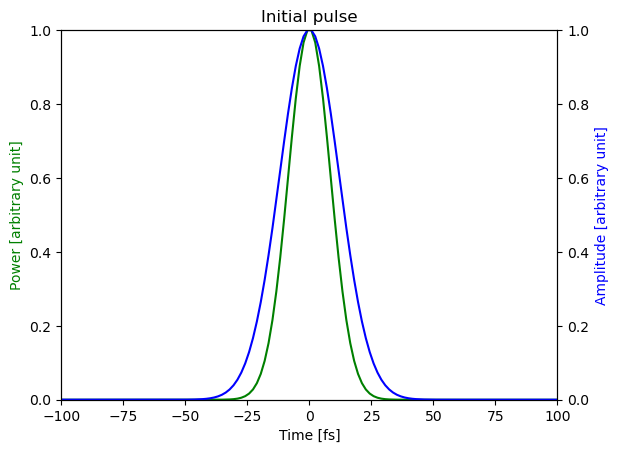

In [6]:
# Initialize Gaussian pulse in the time domain
X, Y, T = np.meshgrid(simulation.x, simulation.y, simulation.t, indexing='ij')
testPulse = GaussianPulse(T,laser.amplitude,laser.tau0, X, Y)
testPulse = testPulse[simulation.nx // 2, simulation.ny // 2, :]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title("Initial pulse")
ax1.plot(simulation.t_fs,getPower(testPulse)/np.max(getPower(testPulse)),'g-')
ax2.plot(simulation.t_fs,abs(testPulse)/np.max(abs(testPulse)),'b-')
ax1.set_xlabel("Time [fs]")
ax1.set_ylabel("Power [arbitrary unit]", color='g')
ax2.set_ylabel("Amplitude [arbitrary unit]", color='b')
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
plt.xlim(-5*laser.tau0*1e15,5*laser.tau0*1e15)
savePlot('initial pulse')
plt.show()

## Testing the defined getSpectrumFromPulse function

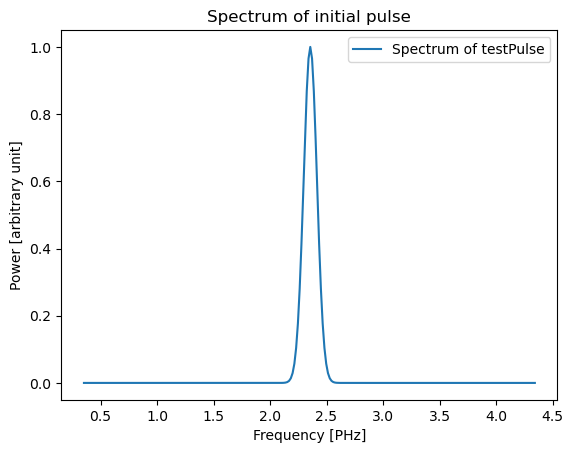

In [7]:
# Getting spectrum from pulse
testSpectrum=getSpectrumFromPulse(simulation.t,testPulse)
plt.figure()
plt.title("Spectrum of initial pulse")
plt.plot(simulation.f_PHz_rel,getPower(testSpectrum)/np.max(getPower(testSpectrum)),label="Spectrum of testPulse")
#plt.axis([-1 + laser.frequency0,1 + laser.frequency0,0,1])
plt.xlabel("Frequency [PHz]")
plt.ylabel("Power [arbitrary unit]")
plt.legend()
savePlot('spectrum of the initial pulse')
plt.show()

## Testing the defined getPulseFromSpectrum function

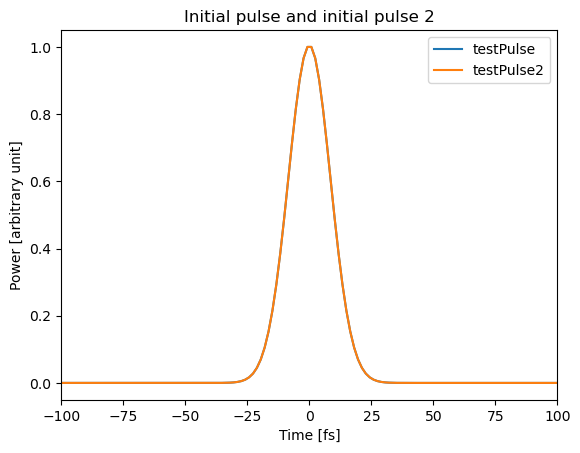

In [8]:
# Getting pulse from spectrum
testPulse2 = getPulseFromSpectrum(simulation.t,testSpectrum)
plt.figure()
plt.title("Initial pulse and initial pulse 2")
plt.plot(simulation.t_fs,getPower(testPulse)/np.max(getPower(testPulse)),label="testPulse")
plt.plot(simulation.t_fs,getPower(testPulse2)/np.max(getPower(testPulse2)),label="testPulse2")
plt.xlim(-5*laser.tau0*1e15,5*laser.tau0*1e15)
plt.xlabel("Time [fs]")
plt.ylabel("Power [arbitrary unit]")
plt.legend()
savePlot('Initial pulse 2')
plt.show()

## Testing the FWHM function

In [9]:
FWHM_frequency=FWHM(simulation.f,getPower(testSpectrum))
FWHM_time=FWHM(simulation.t,getPower(testPulse))
product=FWHM_frequency*FWHM_time
print(f"The product of the pulse and the spectrum's FWHM is {product}")

The product of the pulse and the spectrum's FWHM is 0.42187499999999756


# Some safety stuff

In [10]:
#%%script false
# Calculate CFL for each spatial direction (for both x and y)
CFL_x = (c * simulation.dt) / simulation.dx
CFL_y = (c * simulation.dt) / simulation.dy
# For nonlinear Schrödinger equation, consider the nonlinear term (gamma)
# Here you include a basic term for the nonlinearity (Kerr effect), you may need to adjust this
CFL_nonlinear = (fiber.gamma * simulation.dt) / (simulation.dx)  # Simple estimation of nonlinear influence
# Maximum CFL values for stability
CFL_max = 0.9  # This is typically the maximum stable CFL number; you can adjust this
if CFL_x <= CFL_max and CFL_y <= CFL_max and CFL_nonlinear <= CFL_max:
    print(f"CFL condition is satisfied!")
else:
    raise ValueError('CFL condition NOT satisfied!')

# Compute stability step sizes
W_max = np.max(simulation.w)
dz_est = estimate_stable_dz(fiber.gamma, laser.peak_power, laser.lambda0, n0, fiber.beta2, W_max)
dt_est, dx_est, dy_est = estimate_grid_resolution(laser.tau0, fiber.effective_mode_diameter, W_max)
print('Stable dt value: ',dt_est)
print('Stable dx value: ',dx_est)
print('Stable dy value: ',dy_est)
print('Stable dz value: ',dz_est)

# Calculate critical peak power
P_crit = laser.lambda0**2 / (2*np.pi*n0*fiber.nonlinear_refractive_index)
P_0 = laser.peak_power
if P_0 < P_crit:
    print(f"Crytical power condition is not satisfied for self-focusing!")
else:
    raise ValueError(f'Crytical power condition is satisfied for self focusing!')

# Calculate nonlinear phase shift limit
phi_nl = fiber.gamma*laser.peak_power*simulation.z_max
if phi_nl < 2*np.pi:
    print(f"Clean pulse propagation or compression is achieved!")
else:
    raise ValueError('Significant SPM and pulse distortion!')
# Intensity and physical effect regimes
if laser.peak_intensity <= 1e15:
    print("Linear propagation regime!")
elif (laser.peak_intensity > 1e15 and  laser.peak_intensity <= 1e17):
    print("Kerr + SPM regime!")
elif (laser.peak_intensity > 1e17 and  laser.peak_intensity <= 3e17):
    raise ValueError('Self-focusing threshold regime!')
elif (laser.peak_intensity >= 1e18):
    raise ValueError('Ionization/damage regime!')

# You want N ≥ 1 for at least a fundamental soliton.
N_soliton = np.sqrt(fiber.gamma * laser.peak_power * laser.tau0**2 / np.abs(fiber.beta2))
print("Soliton number:", N_soliton)

CFL condition is satisfied!
Stable dt value:  1.580978848232197e-15
Stable dx value:  5.000000000000001e-07
Stable dy value:  5.000000000000001e-07
Stable dz value:  1.2732395447351628e-08
Crytical power condition is not satisfied for self-focusing!
Clean pulse propagation or compression is achieved!
Kerr + SPM regime!
Soliton number: 6.493499732954829


# Run Simulation

In [11]:
#%%script false
A_snapshots, Energy_values = Simulation(fiber,simulation,laser)

1 % ready
2 % ready
3 % ready
4 % ready
5 % ready
6 % ready
7 % ready
8 % ready
9 % ready
10 % ready
11 % ready
12 % ready
13 % ready
14 % ready
15 % ready
16 % ready
17 % ready
18 % ready
19 % ready
20 % ready
21 % ready
22 % ready
23 % ready
24 % ready
25 % ready
26 % ready
27 % ready
28 % ready
29 % ready
30 % ready
31 % ready
32 % ready
33 % ready
34 % ready
35 % ready
36 % ready
37 % ready
38 % ready
39 % ready
40 % ready
41 % ready
42 % ready
43 % ready
44 % ready
45 % ready
46 % ready
47 % ready
48 % ready
49 % ready
50 % ready
51 % ready
52 % ready
53 % ready
54 % ready
55 % ready
56 % ready
57 % ready
58 % ready
59 % ready
60 % ready
61 % ready
62 % ready
63 % ready
64 % ready
65 % ready
66 % ready
67 % ready
68 % ready
69 % ready
70 % ready
71 % ready
72 % ready
73 % ready
74 % ready
75 % ready
76 % ready
77 % ready
78 % ready
79 % ready
80 % ready
81 % ready
82 % ready
83 % ready
84 % ready
85 % ready
86 % ready
87 % ready
88 % ready
89 % ready
90 % ready
91 % ready
92 % rea

## Initialize functions for plotting the results

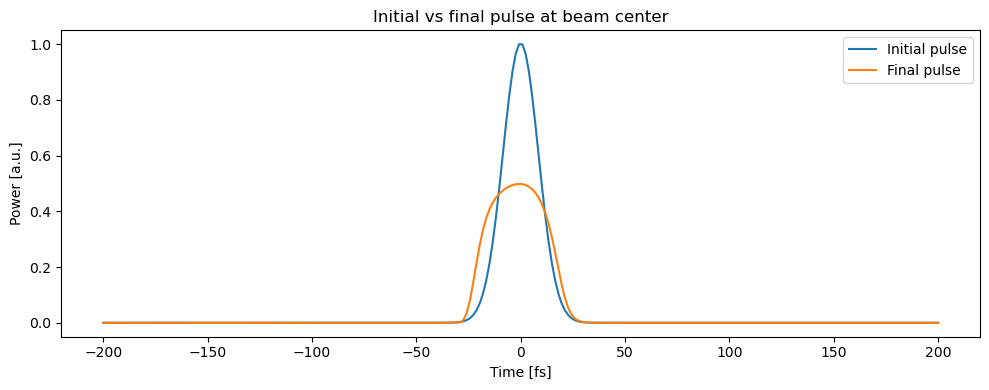

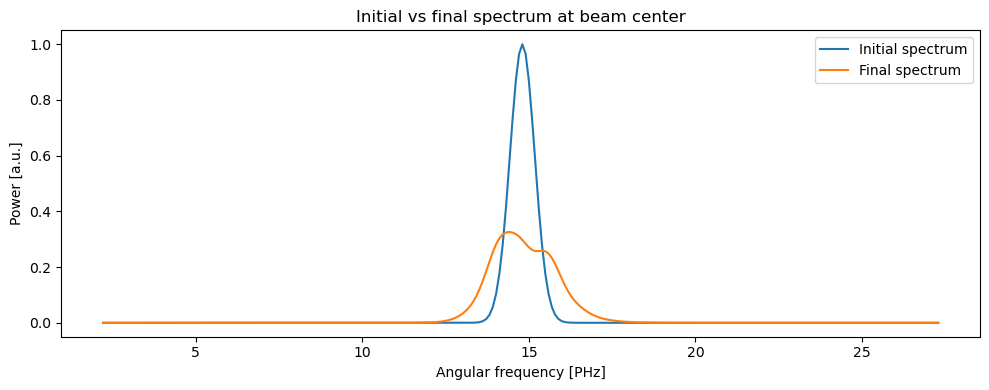

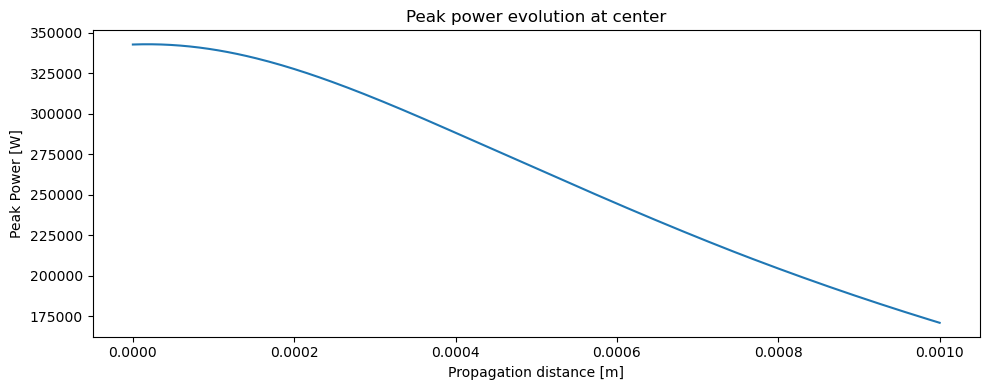

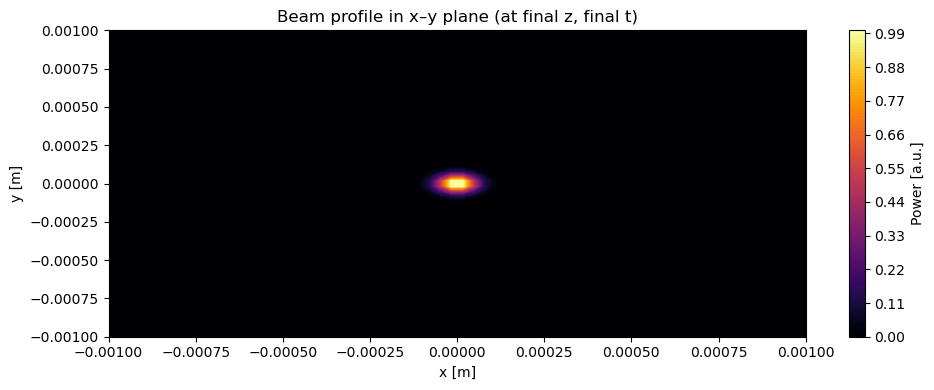

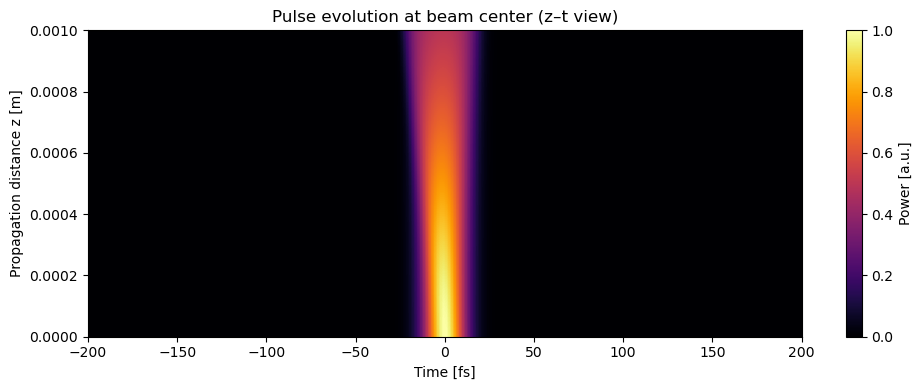

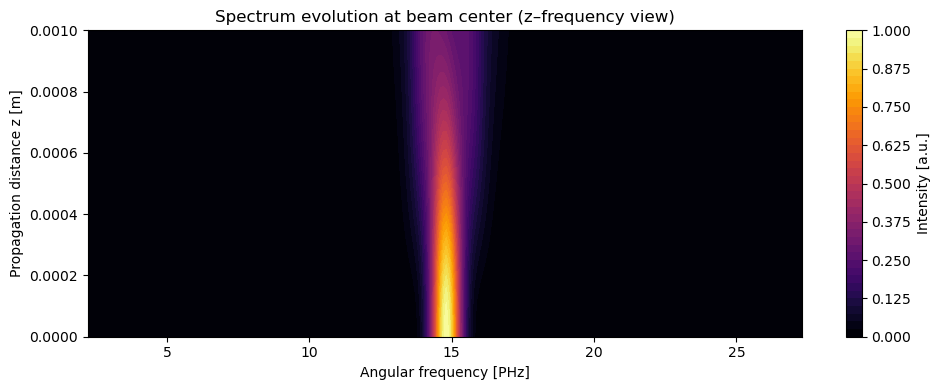

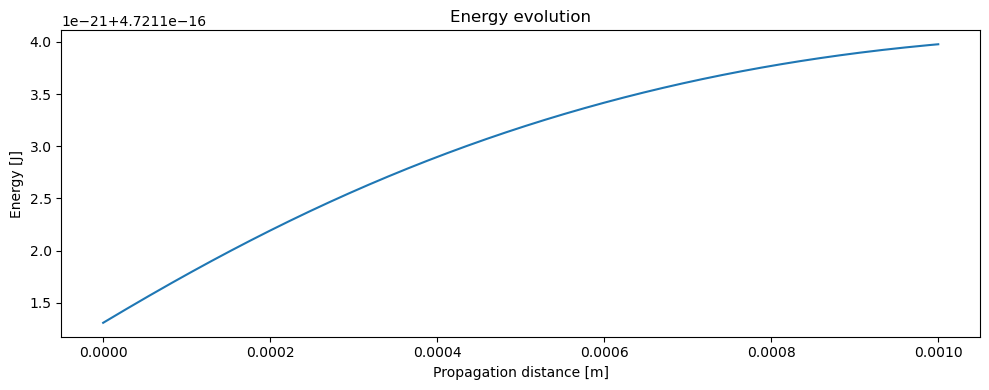

In [12]:
#%%script false
plotFirstAndLastPulse(A_snapshots,simulation)
plotFirstAndLastSpectrum(A_snapshots,simulation)
plotPeakIntensity(A_snapshots,simulation)
plotXYBeamprofile(A_snapshots,simulation)
plotPulseEvolution(A_snapshots,simulation)
plotSpectrumEvolution(A_snapshots,simulation)
plotEnergyValues(Energy_values,simulation)

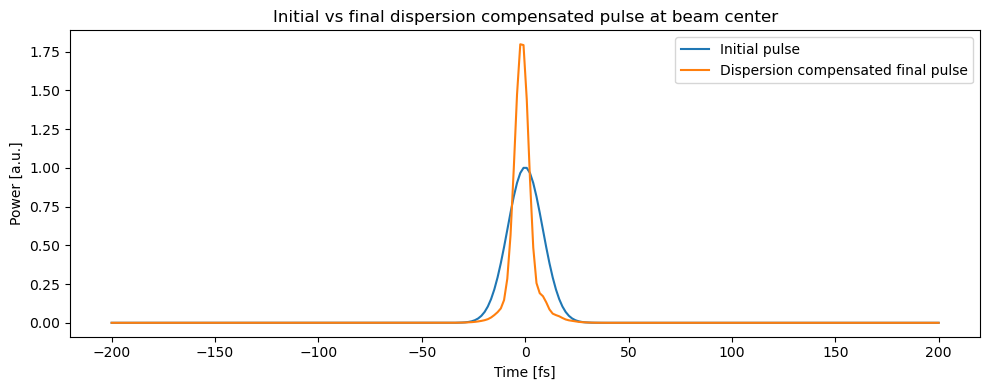

In [13]:
# Apply compressor phase
compressor = COMPRESSOR_config(GDD_mirror,1)
compressor_dispersion = np.exp(1j * compressor.GDD_compressor / 2 * (simulation.w)**2)
initial_pulse = A_snapshots[0][simulation.nx // 2, simulation.ny // 2, :]
initial_pulse = getPower(initial_pulse)
initial_pulse_maximum = np.max(initial_pulse)
initial_pulse /= initial_pulse_maximum
final_pulse = A_snapshots[-1][simulation.nx // 2, simulation.ny // 2, :]
## Apply GDD in frequency domain
final_pulse_fft = fftshift(fft(ifftshift(final_pulse)))
final_pulse_fft *= compressor_dispersion
dispersion_compensated_final_pulse = fftshift(ifft(ifftshift(final_pulse_fft)))
dispersion_compensated_final_pulse = getPower(dispersion_compensated_final_pulse)
dispersion_compensated_final_pulse /= initial_pulse_maximum
# Create a figure for z-t evolution of initial and final pulses
plt.figure(figsize=(10, 4))
# Plot the power as a function of time for both the initial and final pulses
plt.plot(simulation.t_fs, initial_pulse, label='Initial pulse')
plt.plot(simulation.t_fs, dispersion_compensated_final_pulse, label='Dispersion compensated final pulse')
plt.xlabel('Time [fs]')
plt.ylabel('Power [a.u.]')
plt.title('Initial vs final dispersion compensated pulse at beam center')
plt.legend()
plt.tight_layout()
savePlot('Initial vs final dispersion compensated pulse at beam center')
plt.show()